In [2]:
import json
import gzip
from rdkit import Chem
from uuid import uuid4
import numpy as np
from datetime import datetime
from typing import Union
import os
import pandas as pd
from pandas import to_datetime
from tqdm.notebook import tqdm
from dask.distributed import Client, progress
import dask
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import Fragments

import warnings
from scipy.sparse import SparseEfficiencyWarning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

warnings.simplefilter('ignore',SparseEfficiencyWarning)

ModuleNotFoundError: No module named 'dask'

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
file_path = '/eagle/ExaMol/mofa/mof-generation-at-scale/scripts/prod-runs/450-nodes/all_ligands.csv.gz'

if file_path.endswith('gz'):
    json_objects = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        try:
            df = pd.read_csv(file)
        except json.JSONDecodeError as e:
            print(f"Error decoding CSV")
            print(e)
else:
    json_objects = []
    with open(file_path, 'rt', encoding='utf-8') as file:
        try:
            df = pd.read_csv(file)
        except json.JSONDecodeError as e:
            print(f"Error decoding CSV")
            print(e)



In [4]:
df.shape

(4946944, 7)

In [5]:
(~df[df.valid].smiles.isna()).all()

True

In [6]:
df.columns

Index(['anchor_type', 'name', 'smiles', 'xyz', 'prompt_atoms', 'valid',
       'model_version'],
      dtype='object')

In [7]:
df[df.valid].shape

(1131063, 7)

In [8]:

def generate_features(smiles_list):
  
    descriptor_funcs = {
        'Molecular_Weight': Descriptors.MolWt,
        'LogP': Descriptors.MolLogP,
        'Num_H_Donors': Descriptors.NumHDonors,
        'Num_H_Acceptors': Descriptors.NumHAcceptors,
        'TPSA': rdMolDescriptors.CalcTPSA,
        'Num_Rotatable_Bonds': Lipinski.NumRotatableBonds,
        'Molar_Refractivity': Crippen.MolMR,
        'Heavy_Atom_Count': Descriptors.HeavyAtomCount,
        'NHOH_Count': Descriptors.NHOHCount,
        'NO_Count': Descriptors.NOCount,
        'Num_Alipathic_Rings': Descriptors.NumAliphaticRings,
        'Num_Aromatic_Rings': Descriptors.NumAromaticRings,
        'Num_Saturated_Rings': Descriptors.NumSaturatedRings,
        'Num_Heteroatoms': Descriptors.NumHeteroatoms,
        'Balaban_J': GraphDescriptors.BalabanJ,
        'LabuteASA': rdMolDescriptors.CalcLabuteASA,
        'Chi0v': GraphDescriptors.Chi0v,
        'Chi1v': GraphDescriptors.Chi1v,
        'HallKierAlpha': Descriptors.HallKierAlpha,
        'Kappa1': Descriptors.Kappa1,
        'Num_Valence_Electrons': Descriptors.NumValenceElectrons,
        'Num_Aromatic_Heterocycles': Descriptors.NumAromaticHeterocycles,
        'Num_Aromatic_Carbocycles': Descriptors.NumAromaticCarbocycles,
        'Num_SpiroAtoms': rdMolDescriptors.CalcNumSpiroAtoms,
        'Num_Bridgehead_Atoms': rdMolDescriptors.CalcNumBridgeheadAtoms,

        'clogp': Crippen.MolLogP,
        'mr': Crippen.MolMR,
        'Chi0n': rdMolDescriptors.CalcChi0n,
        'Chi1n': rdMolDescriptors.CalcChi1n,
        'Chi2n': rdMolDescriptors.CalcChi2n,
        'Chi3n': rdMolDescriptors.CalcChi3n,
        'Chi4n': rdMolDescriptors.CalcChi4n,
        'Chi0v': rdMolDescriptors.CalcChi0v,
        'Chi1v': rdMolDescriptors.CalcChi1v,
        'Chi2v': rdMolDescriptors.CalcChi2v,
        'Chi3v': rdMolDescriptors.CalcChi3v,
        'Chi4v': rdMolDescriptors.CalcChi4v,
        'fracsp3': rdMolDescriptors.CalcFractionCSP3,
        'Hall_Kier_Alpha': rdMolDescriptors.CalcHallKierAlpha,
        'Kappa1': rdMolDescriptors.CalcKappa1,
        'Kappa2': rdMolDescriptors.CalcKappa2,
        'Kappa3': rdMolDescriptors.CalcKappa3,
        'LabuteASA': rdMolDescriptors.CalcLabuteASA,
        'Number_Aliphatic_Rings': rdMolDescriptors.CalcNumAliphaticRings,
        'Number_Aromatic_Rings': rdMolDescriptors.CalcNumAromaticRings,
        'Number_Amide_Bonds': rdMolDescriptors.CalcNumAmideBonds,
        'Number_Atom_Stereocenters': rdMolDescriptors.CalcNumAtomStereoCenters,
        'Number_BridgeHead_Atoms': rdMolDescriptors.CalcNumBridgeheadAtoms,
        'Number_HBA': rdMolDescriptors.CalcNumHBA,
        'Number_HBD': rdMolDescriptors.CalcNumHBD,
        'Number_Hetero_Atoms': rdMolDescriptors.CalcNumHeteroatoms,
        'Number_Hetero_Cycles': rdMolDescriptors.CalcNumHeterocycles,
        'Number_Rings': rdMolDescriptors.CalcNumRings,
        'Number_Rotatable_Bonds':rdMolDescriptors.CalcNumRotatableBonds,
        'Number_Spiro': rdMolDescriptors.CalcNumSpiroAtoms,
        'Number_Saturated_Rings': rdMolDescriptors.CalcNumSaturatedRings,
        'Number_Heavy_Atoms': Lipinski.HeavyAtomCount,
        'Number_NH_OH': Lipinski.NHOHCount,
        'Number_N_O': Lipinski.NOCount,
        'Number_Valence_Electrons': Descriptors.NumValenceElectrons,
        'Max_Partial_Charge': Descriptors.MaxPartialCharge,
        'Min_Partial_Charge': Descriptors.MinPartialCharge,
    }
    
    features_df = pd.DataFrame(columns=descriptor_funcs.keys())    
    for i, smiles in enumerate(tqdm(smiles_list)):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            row = {}
            row['smiles_string'] = smiles
            for desc_name, desc_func in descriptor_funcs.items():
                row[desc_name] = float('nan')
            features_df = features_df.append(pd.Series(row, index=descriptor_funcs.keys()), ignore_index=True)
        else:
            row = {}
            row['smiles_string'] = smiles
            for desc_name, desc_func in descriptor_funcs.items():
                try:
                    row[desc_name] = desc_func(mol)
                except Exception as e:
                    print(f"Error calculating {desc_name} for SMILES {smiles}: {str(e)}")
                    row[desc_name] = float('nan')
            features_df = pd.concat([features_df, pd.DataFrame([row])], ignore_index=True)

    return features_df

In [8]:
from multiprocessing import Pool

@dask.delayed
def process_smiles(smiles):
    descriptor_funcs = {
        'Molecular_Weight': Descriptors.MolWt,
        'LogP': Descriptors.MolLogP,
        'Num_H_Donors': Descriptors.NumHDonors,
        'Num_H_Acceptors': Descriptors.NumHAcceptors,
        'TPSA': rdMolDescriptors.CalcTPSA,
        'Num_Rotatable_Bonds': Lipinski.NumRotatableBonds,
        'Molar_Refractivity': Crippen.MolMR,
        'Heavy_Atom_Count': Descriptors.HeavyAtomCount,
        'NHOH_Count': Descriptors.NHOHCount,
        'NO_Count': Descriptors.NOCount,
        'Num_Alipathic_Rings': Descriptors.NumAliphaticRings,
        'Num_Aromatic_Rings': Descriptors.NumAromaticRings,
        'Num_Saturated_Rings': Descriptors.NumSaturatedRings,
        'Num_Heteroatoms': Descriptors.NumHeteroatoms,
        'Balaban_J': GraphDescriptors.BalabanJ,
        'LabuteASA': rdMolDescriptors.CalcLabuteASA,
        'Chi0v': GraphDescriptors.Chi0v,
        'Chi1v': GraphDescriptors.Chi1v,
        'HallKierAlpha': Descriptors.HallKierAlpha,
        'Kappa1': Descriptors.Kappa1,
        'Num_Valence_Electrons': Descriptors.NumValenceElectrons,
        'Num_Aromatic_Heterocycles': Descriptors.NumAromaticHeterocycles,
        'Num_Aromatic_Carbocycles': Descriptors.NumAromaticCarbocycles,
        'Num_SpiroAtoms': rdMolDescriptors.CalcNumSpiroAtoms,
        'Num_Bridgehead_Atoms': rdMolDescriptors.CalcNumBridgeheadAtoms,

        'clogp': Crippen.MolLogP,
        'mr': Crippen.MolMR,
        'Chi0n': rdMolDescriptors.CalcChi0n,
        'Chi1n': rdMolDescriptors.CalcChi1n,
        'Chi2n': rdMolDescriptors.CalcChi2n,
        'Chi3n': rdMolDescriptors.CalcChi3n,
        'Chi4n': rdMolDescriptors.CalcChi4n,
        'Chi0v': rdMolDescriptors.CalcChi0v,
        'Chi1v': rdMolDescriptors.CalcChi1v,
        'Chi2v': rdMolDescriptors.CalcChi2v,
        'Chi3v': rdMolDescriptors.CalcChi3v,
        'Chi4v': rdMolDescriptors.CalcChi4v,
        'fracsp3': rdMolDescriptors.CalcFractionCSP3,
        'Hall_Kier_Alpha': rdMolDescriptors.CalcHallKierAlpha,
        'Kappa1': rdMolDescriptors.CalcKappa1,
        'Kappa2': rdMolDescriptors.CalcKappa2,
        'Kappa3': rdMolDescriptors.CalcKappa3,
        'LabuteASA': rdMolDescriptors.CalcLabuteASA,
        'Number_Aliphatic_Rings': rdMolDescriptors.CalcNumAliphaticRings,
        'Number_Aromatic_Rings': rdMolDescriptors.CalcNumAromaticRings,
        'Number_Amide_Bonds': rdMolDescriptors.CalcNumAmideBonds,
        'Number_Atom_Stereocenters': rdMolDescriptors.CalcNumAtomStereoCenters,
        'Number_BridgeHead_Atoms': rdMolDescriptors.CalcNumBridgeheadAtoms,
        'Number_HBA': rdMolDescriptors.CalcNumHBA,
        'Number_HBD': rdMolDescriptors.CalcNumHBD,
        'Number_Hetero_Atoms': rdMolDescriptors.CalcNumHeteroatoms,
        'Number_Hetero_Cycles': rdMolDescriptors.CalcNumHeterocycles,
        'Number_Rings': rdMolDescriptors.CalcNumRings,
        'Number_Rotatable_Bonds':rdMolDescriptors.CalcNumRotatableBonds,
        'Number_Spiro': rdMolDescriptors.CalcNumSpiroAtoms,
        'Number_Saturated_Rings': rdMolDescriptors.CalcNumSaturatedRings,
        'Number_Heavy_Atoms': Lipinski.HeavyAtomCount,
        'Number_NH_OH': Lipinski.NHOHCount,
        'Number_N_O': Lipinski.NOCount,
        'Number_Valence_Electrons': Descriptors.NumValenceElectrons,
        'Max_Partial_Charge': Descriptors.MaxPartialCharge,
        'Min_Partial_Charge': Descriptors.MinPartialCharge,
    }
    mol = Chem.MolFromSmiles(smiles)
    row = {'smiles_string': smiles}
    if mol is None:
        for desc_name in descriptor_funcs.keys():
            row[desc_name] = float('nan')
    else:
        for desc_name, desc_func in descriptor_funcs.items():
            try:
                row[desc_name] = desc_func(mol)
            except Exception as e:
                print(f"Error calculating {desc_name} for SMILES {smiles}: {str(e)}")
                row[desc_name] = float('nan')
    return row



NameError: name 'dask' is not defined

In [10]:
def compute_descriptors(smiles_list):
    results = []
    for smile in smiles_list:
        results.append(process_smiles(smile))
    dask.compute(results)
    progress(results)
    return pd.DataFrame.from_records(results)

In [11]:
list_of_smiles = df[df.valid].smiles.tolist()

In [12]:
len(list_of_smiles)

1131063

In [13]:
client = Client(n_workers = 64)

In [ ]:
features = compute_descriptors(list_of_smiles)

/home/grzenda/.local/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 167.14 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
[21:14:05] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[21:14:07] Conflicting single bond directions around double bond at index 30.
[21:14:07]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:14:07] Conflicting single bond directions around double bond at index 15.
[21:14:07]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:14:07] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[21:14:09] Conflicting single bond directions around double bond at index 23.
[21:14:09]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:14:11] Conflicting single bond directions around double bond at index 4.
[21:

In [ ]:
essential_plot_cols = [col for col in features.columns if col not in ['smiles_string', 'creation_time']]

In [150]:
def remove_correlated_features(df, essential_cols=None, threshold=0.99):
    """
    Removes highly correlated features from a DataFrame, keeping the first of the correlated columns.
    
    Parameters:
    - df: pandas.DataFrame
    - threshold: float, features are removed if their correlations are above this value
    
    Returns:
    - df: pandas.DataFrame, with highly correlated features removed
    """
    ignored_cols = [col for col in df.columns if col not in essential_cols] 
    ignored_df = df[ignored_cols]
    df = df[essential_cols]
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # List to hold pairs of correlated columns
    correlated_pairs = []

    # Find index of feature columns with correlation greater than the threshold
    to_drop = set()
    for row in range(len(upper_tri)):
        for col in range(row + 1, len(upper_tri.columns)):
            if upper_tri.iat[row, col] > threshold:  # check if correlation exceeds threshold
                col_name = upper_tri.columns[col]
                row_name = upper_tri.columns[row]
                correlated_pairs.append((row_name, col_name))
                to_drop.add(col_name)  # add the later column name in the pair

    # Print correlated pairs
    print("Correlated pairs above the threshold:")
    for pair in correlated_pairs:
        print(pair)

    # Drop the features
    df_reduced = df.drop(to_drop, axis=1)
    df_reduced = pd.concat([df_reduced, ignored_df], axis=1)
    
    return df_reduced

In [151]:
features.head()

,smiles_string,Molecular_Weight,LogP,Num_H_Donors,Num_H_Acceptors,TPSA,Num_Rotatable_Bonds,Molar_Refractivity,Heavy_Atom_Count,NHOH_Count,NO_Count,Num_Alipathic_Rings,Num_Aromatic_Rings,Num_Saturated_Rings,Num_Heteroatoms,Balaban_J,LabuteASA,Chi0v,Chi1v,HallKierAlpha,Kappa1,Num_Valence_Electrons,Num_Aromatic_Heterocycles,Num_Aromatic_Carbocycles,Num_SpiroAtoms,Num_Bridgehead_Atoms,clogp,mr,Chi0n,Chi1n,Chi2n,Chi3n,Chi4n,Chi2v,Chi3v,Chi4v,fracsp3,Hall_Kier_Alpha,Kappa2,Kappa3,Number_Aliphatic_Rings,Number_Aromatic_Rings,Number_Amide_Bonds,Number_Atom_Stereocenters,Number_BridgeHead_Atoms,Number_HBA,Number_HBD,Number_Hetero_Atoms,Number_Hetero_Cycles,Number_Rings,Number_Rotatable_Bonds,Number_Spiro,Number_Saturated_Rings,Number_Heavy_Atoms,Number_NH_OH,Number_N_O,Number_Valence_Electrons,Max_Partial_Charge,Min_Partial_Charge
0,[N-2][C][c+]1[cH-][cH+][c-]([C][CH+][C][C][CH+...,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,142.579485,12.16793,6.744649,-1.64,17.709781,104,0,1,0,0,3.93115,86.351,12.16793,6.744649,4.369333,2.783181,1.627338,4.369333,2.783181,1.627338,0.0,-1.64,10.194274,6.553995,1,1,0,0,0,0,0,2,0,2,10,0,1,23,0,2,104,0.373018,-1.586972
1,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,142.579485,12.16793,6.750632,-1.64,17.709781,104,0,1,0,0,3.93115,86.351,12.16793,6.750632,4.375316,2.786172,1.629814,4.375316,2.786172,1.629814,0.0,-1.64,10.194274,6.553995,1,1,0,0,0,0,0,2,0,2,10,0,1,23,0,2,104,0.507578,-1.586972
2,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,142.579485,12.16793,6.750632,-1.64,17.709781,104,0,1,0,0,3.93115,86.351,12.16793,6.750632,4.375316,2.786172,1.629814,4.375316,2.786172,1.629814,0.0,-1.64,10.194274,6.553995,1,1,0,0,0,0,0,2,0,2,10,0,1,23,0,2,104,0.507578,-1.586972
3,[N-2][C][c+]1[cH-][cH+][c-]([C][CH+][C][C][CH+...,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,142.579485,12.16793,6.744649,-1.64,17.709781,104,0,1,0,0,3.93115,86.351,12.16793,6.744649,4.369333,2.783181,1.627338,4.369333,2.783181,1.627338,0.0,-1.64,10.194274,6.553995,1,1,0,0,0,0,0,2,0,2,10,0,1,23,0,2,104,0.373018,-1.586972
4,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,142.579485,12.16793,6.750632,-1.64,17.709781,104,0,1,0,0,3.93115,86.351,12.16793,6.750632,4.375316,2.786172,1.629814,4.375316,2.786172,1.629814,0.0,-1.64,10.194274,6.553995,1,1,0,0,0,0,0,2,0,2,10,0,1,23,0,2,104,0.507578,-1.586972


In [152]:
features.shape

(1131063, 59)

In [153]:
features = remove_correlated_features(features, essential_cols=essential_plot_cols)

Correlated pairs above the threshold:
('Molecular_Weight', 'Num_Valence_Electrons')
('Molecular_Weight', 'Number_Valence_Electrons')
('LogP', 'clogp')
('Num_H_Donors', 'Number_HBD')
('Num_H_Acceptors', 'Number_HBA')
('Num_Rotatable_Bonds', 'Number_Rotatable_Bonds')
('Molar_Refractivity', 'mr')
('Heavy_Atom_Count', 'LabuteASA')
('Heavy_Atom_Count', 'Num_Valence_Electrons')
('Heavy_Atom_Count', 'Number_Heavy_Atoms')
('Heavy_Atom_Count', 'Number_Valence_Electrons')
('NHOH_Count', 'Number_NH_OH')
('NO_Count', 'Number_N_O')
('Num_Alipathic_Rings', 'Number_Aliphatic_Rings')
('Num_Aromatic_Rings', 'Number_Aromatic_Rings')
('Num_Saturated_Rings', 'Number_Saturated_Rings')
('Num_Heteroatoms', 'Number_Hetero_Atoms')
('LabuteASA', 'Chi0v')
('LabuteASA', 'Number_Heavy_Atoms')
('HallKierAlpha', 'Hall_Kier_Alpha')
('Num_Valence_Electrons', 'Number_Heavy_Atoms')
('Num_Valence_Electrons', 'Number_Valence_Electrons')
('Num_SpiroAtoms', 'Number_Spiro')
('Num_Bridgehead_Atoms', 'Number_BridgeHead_Atoms')

In [154]:
features.head()

,Molecular_Weight,LogP,Num_H_Donors,Num_H_Acceptors,TPSA,Num_Rotatable_Bonds,Molar_Refractivity,Heavy_Atom_Count,NHOH_Count,NO_Count,Num_Alipathic_Rings,Num_Aromatic_Rings,Num_Saturated_Rings,Num_Heteroatoms,Balaban_J,Chi1v,HallKierAlpha,Kappa1,Num_Aromatic_Heterocycles,Num_Aromatic_Carbocycles,Num_SpiroAtoms,Num_Bridgehead_Atoms,Chi0n,Chi1n,Chi2n,Chi3n,Chi2v,Chi3v,fracsp3,Kappa2,Kappa3,Number_Amide_Bonds,Number_Atom_Stereocenters,Number_Hetero_Cycles,Number_Rings,Max_Partial_Charge,Min_Partial_Charge,smiles_string
0,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.744649,-1.64,17.709781,0,1,0,0,12.16793,6.744649,4.369333,2.783181,4.369333,2.783181,0.0,10.194274,6.553995,0,0,0,2,0.373018,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][CH+][C][C][CH+...
1,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.750632,-1.64,17.709781,0,1,0,0,12.16793,6.750632,4.375316,2.786172,4.375316,2.786172,0.0,10.194274,6.553995,0,0,0,2,0.507578,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...
2,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.750632,-1.64,17.709781,0,1,0,0,12.16793,6.750632,4.375316,2.786172,4.375316,2.786172,0.0,10.194274,6.553995,0,0,0,2,0.507578,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...
3,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.744649,-1.64,17.709781,0,1,0,0,12.16793,6.744649,4.369333,2.783181,4.369333,2.783181,0.0,10.194274,6.553995,0,0,0,2,0.373018,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][CH+][C][C][CH+...
4,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.750632,-1.64,17.709781,0,1,0,0,12.16793,6.750632,4.375316,2.786172,4.375316,2.786172,0.0,10.194274,6.553995,0,0,0,2,0.507578,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...


In [155]:
features.shape

(1131063, 38)

In [156]:
essential_plot_cols = [col for col in features.columns if col not in ['smiles_string', 'creation_time']]

In [157]:
inf_mask = features[essential_plot_cols].applymap(np.isinf)

In [158]:
inf_counts = inf_mask.sum()
inf_counts

Molecular_Weight               0
LogP                           0
Num_H_Donors                   0
Num_H_Acceptors                0
TPSA                           0
Num_Rotatable_Bonds            0
Molar_Refractivity             0
Heavy_Atom_Count               0
NHOH_Count                     0
NO_Count                       0
Num_Alipathic_Rings            0
Num_Aromatic_Rings             0
Num_Saturated_Rings            0
Num_Heteroatoms                0
Balaban_J                      0
Chi1v                          0
HallKierAlpha                  0
Kappa1                         0
Num_Aromatic_Heterocycles      0
Num_Aromatic_Carbocycles       0
Num_SpiroAtoms                 0
Num_Bridgehead_Atoms           0
Chi0n                          0
Chi1n                          0
Chi2n                          0
Chi3n                          0
Chi2v                          0
Chi3v                          0
fracsp3                        0
Kappa2                         0
Kappa3    

In [159]:
features = features[~inf_mask.any(axis=1)]

In [160]:
features.head()

,Molecular_Weight,LogP,Num_H_Donors,Num_H_Acceptors,TPSA,Num_Rotatable_Bonds,Molar_Refractivity,Heavy_Atom_Count,NHOH_Count,NO_Count,Num_Alipathic_Rings,Num_Aromatic_Rings,Num_Saturated_Rings,Num_Heteroatoms,Balaban_J,Chi1v,HallKierAlpha,Kappa1,Num_Aromatic_Heterocycles,Num_Aromatic_Carbocycles,Num_SpiroAtoms,Num_Bridgehead_Atoms,Chi0n,Chi1n,Chi2n,Chi3n,Chi2v,Chi3v,fracsp3,Kappa2,Kappa3,Number_Amide_Bonds,Number_Atom_Stereocenters,Number_Hetero_Cycles,Number_Rings,Max_Partial_Charge,Min_Partial_Charge,smiles_string
0,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.744649,-1.64,17.709781,0,1,0,0,12.16793,6.744649,4.369333,2.783181,4.369333,2.783181,0.0,10.194274,6.553995,0,0,0,2,0.373018,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][CH+][C][C][CH+...
1,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.750632,-1.64,17.709781,0,1,0,0,12.16793,6.750632,4.375316,2.786172,4.375316,2.786172,0.0,10.194274,6.553995,0,0,0,2,0.507578,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...
2,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.750632,-1.64,17.709781,0,1,0,0,12.16793,6.750632,4.375316,2.786172,4.375316,2.786172,0.0,10.194274,6.553995,0,0,0,2,0.507578,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...
3,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.744649,-1.64,17.709781,0,1,0,0,12.16793,6.744649,4.369333,2.783181,4.369333,2.783181,0.0,10.194274,6.553995,0,0,0,2,0.373018,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][CH+][C][C][CH+...
4,290.325,3.93115,0,0,44.6,10,86.351,23,0,2,1,1,1,2,1.447113,6.750632,-1.64,17.709781,0,1,0,0,12.16793,6.750632,4.375316,2.786172,4.375316,2.786172,0.0,10.194274,6.553995,0,0,0,2,0.507578,-1.586972,[N-2][C][c+]1[cH-][cH+][c-]([C][C][C][C][CH+][...


In [161]:
def plot_isomap_projection(features_df, n_neighbors=20, n_components=2):
    clean_df = features_df.dropna()
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df)
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    projected_features = isomap.fit_transform(features_scaled)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_features[:, 0], projected_features[:, 1], edgecolor='k', alpha=0.7, s=50)
    plt.title(f'2D Isomap Projection of Molecular Descriptors with {n_neighbors} neighbors')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

    return projected_features

In [162]:
#plot_isomap_projection(features[essential_plot_cols])

In [163]:
def plot_pca_projection(features_df, n_components=2):
    # Drop any rows with NaN values to avoid errors with PCA
    clean_df = features_df.dropna()
    
    # Standardizing the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df)
    
    # Applying PCA
    pca = PCA(n_components=n_components)
    projected_features = pca.fit_transform(features_scaled)
    
    # Creating the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_features[:, 0], projected_features[:, 1], edgecolor='k', alpha=0.7, s=50)
    plt.title('2D PCA Projection of Molecular Descriptors')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

In [164]:
#plot_pca_projection(features[essential_plot_cols])

In [165]:
def plot_tsne_projection(features_df, n_components=2, perplexity=30, n_iter=1000):
    # Drop any rows with NaN values to avoid errors with t-SNE
    essential_cols = [col for col in features_df.columns if col not in ['strain', 'smiles_string', 'creation_time']]
    clean_df = features_df.dropna(subset=essential_cols)

    # Standardizing the features (excluding 'strain' which is categorical)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df[essential_cols])
    
    # Applying t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    projected_features = tsne.fit_transform(features_scaled)
    
    # Creating the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_features[:, 0], projected_features[:, 1], edgecolor='k', alpha=0.5)
    plt.title('2D t-SNE Projection of Molecular Descriptors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

    return projected_features

In [166]:
def plot_tsne_projection_time_and_strain(features_df, n_components=2, perplexity=30, n_iter=1000):
    # Drop any rows with NaN values to avoid errors with t-SNE
    essential_cols = [col for col in features_df.columns if col not in ['strain', 'smiles_string', 'creation_time']]
    clean_df = features_df.dropna(subset=essential_cols)
    clean_df['creation_time'] = to_datetime(clean_df['creation_time'])

    # Standardizing the features (excluding 'strain' which is categorical)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df[essential_cols])
    
    # Applying t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    projected_features = tsne.fit_transform(features_scaled)

    min_date = clean_df['creation_time'].min()
    print(min_date)
    clean_df['seconds_since_min'] = (clean_df['creation_time'] - min_date).dt.seconds
    clean_df['normalized_seconds'] = clean_df['seconds_since_min'] / (np.nanmax(clean_df['seconds_since_min']) - np.nanmin(clean_df['seconds_since_min']))
    strain_values = clean_df['strain'].values
    time_values = clean_df['normalized_seconds'].values

    clean_df['Time (min)'] = clean_df['seconds_since_min'] / 60  
    clean_df['Normalized Time'] = (clean_df['Time (min)'] - clean_df['Time (min)'].min()) / (clean_df['Time (min)'].max() - clean_df['Time (min)'].min())
    
    size_norm = mcolors.Normalize(vmin=np.nanmin(time_values), vmax=np.nanmax(time_values))
    norm = mcolors.Normalize(vmin=np.nanmin(strain_values), vmax=np.nanmax(strain_values), clip=True)
    
    # Create a yellow to red colormap
    yellow_red = mcolors.LinearSegmentedColormap.from_list("", ["yellow", "red"])
    
    # Map 'strain' values to colors, NaNs to blue
    point_colors = [yellow_red(norm(value)) if not np.isnan(value) else [0, 0, 1, 1] for value in strain_values]
    point_sizes = [size_norm(value) for value in time_values]  # Scale sizes between 100 and 1000
    
    # Creating the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_features[:, 0], projected_features[:, 1], color=point_colors, 
                s=1, edgecolor='k', alpha=clean_df['Normalized Time'])
    plt.title('2D t-SNE Projection of Molecular Descriptors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=yellow_red), label='Strain')
    plt.grid(True)
    plt.show()

    return projected_features

In [167]:
def get_tsne_projection(features_df, n_components=2, perplexity=30, n_iter=1000, cols_to_drop=['strain', 'smiles_string', 'creation_time']):
    essential_cols = [col for col in features_df.columns if col not in cols_to_drop]
    clean_df = features_df.dropna(subset=essential_cols)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df[essential_cols])
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    projected_features = tsne.fit_transform(features_scaled)
    return projected_features, clean_df

In [171]:
file_path = '../../datasets/mofs_450.json.gz'

json_objects = []
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    for line in tqdm(file):
        try:
            json_object = json.loads(line)
            json_objects.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from line: {line}")
            print(e)

0it [00:00, ?it/s]

EOFError: Compressed file ended before the end-of-stream marker was reached

In [169]:
for json_object in tqdm(json_objects):
    for ligand in json_object['ligands']:
        if ligand['smiles'] in list(features.smiles_string):
            idx = features[features['smiles_string'] == ligand['smiles']].index
            features.loc[idx, 'strain'] = json_object['structure_stability']['uff']
            try:
                features.loc[idx, 'co2_affin'] = json_object['gas_storage']['CO2'][1]
            except:
                features.loc[idx, 'co2_affin'] = np.nan
            features.loc[idx, 'creation_time'] = json_object['times']['created']['$date']
        else:
            print(f"Ligand not found: {ligand['smiles']}")

  0%|          | 0/10001 [00:00<?, ?it/s]

Ligand not found: O=C([O-])c1ccc(/C=N/C=[O+]/C/C=C\C(=O)c2ccc(C(=O)O)cc2)cc1
Ligand not found: O=C([O-])c1ccc(/C=N/C=[O+]/C/C=C\C(=O)c2ccc(C(=O)O)cc2)cc1
Ligand not found: N#Cc1ccc(/C=C/C=[O+]/C=N\N=N/C=c2ccc(=C=[N-])cc2)cc1
Ligand not found: N#Cc1ccc(/C=N/N=N/C=C/O/N=N/c2ccc(C#N)cc2)cc1


KeyboardInterrupt: 

In [38]:
json_objects[0]['gas_storage']['CO2'][1]

0.9462080674

In [39]:
features.shape

(127778, 40)

In [40]:
features['co2_affin'].isna().sum()

127715

In [41]:
projected_features, clean_df = get_tsne_projection(features)

In [47]:
def plot_tsne_with_strain_and_time(projected_features, clean_df, figsize=(8, 6)):
    """
    Plots t-SNE components with strain represented by color and creation time by the opacity of points.

    Parameters:
    projected_features (np.array): Numpy array with shape (n_samples, 2) containing t-SNE projections.
    clean_df (pd.DataFrame): DataFrame with 'strain' and 'creation_time' columns.
    figsize (tuple): Tuple representing the figure size.
    """
    # Ensure 'projected_features' and 'clean_df' have the same length
    assert len(projected_features) == len(clean_df), "Mismatch in lengths of projected_features and clean_df"
    clean_df['creation_time'] = to_datetime(clean_df['creation_time'])

    # Filter out NaN values for 'strain' and 'creation_time'
    valid_indices = clean_df.dropna(subset=['strain', 'creation_time']).index
    filtered_features = projected_features[valid_indices]
    filtered_df = clean_df.loc[valid_indices]
    
    min_time = filtered_df['creation_time'].min()
    max_time = filtered_df['creation_time'].max()
    creation_time_normalized = (filtered_df['creation_time'] - min_time) / (max_time - min_time)

    # Adjust opacity: scale to range from 0.1 to 1.0
    opacity = 0.1 + 0.9 * creation_time_normalized  # Now, opacity ranges from 0.1 to 1.0
    c_map = mcolors.LinearSegmentedColormap.from_list("custom_yellow_red", ["blue", "red"], N=256)
    
    # Plotting
    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        filtered_features[:, 0],  # t-SNE component 1
        filtered_features[:, 1],  # t-SNE component 2
        c=filtered_df['strain'],  # Color by strain
        cmap=c_map,  # Color map
        s=50,
        alpha=opacity,  # Opacity by creation_time, ensuring minimum opacity for visibility
        edgecolor='none'
    )

    legend_elements = [Patch(facecolor='gray', edgecolor='none', label='Earlier Time', alpha=0.1 + 0.9 * 0),
                       Patch(facecolor='gray', edgecolor='none', label='Middle Time', alpha=0.1 + 0.9 * 0.5),
                       Patch(facecolor='gray', edgecolor='none', label='Later Time', alpha=0.1 + 0.9 * 1)]
    plt.legend(handles=legend_elements, title="Creation Time", loc='lower right')

    
    plt.colorbar(scatter, label='Strain')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Projection with CO2 Affinity Color and Creation Time Opacity')
    plt.show()

In [48]:
len(clean_df)

63

In [49]:
len(projected_features)

63

In [50]:
clean_df = clean_df.reset_index(drop=True)

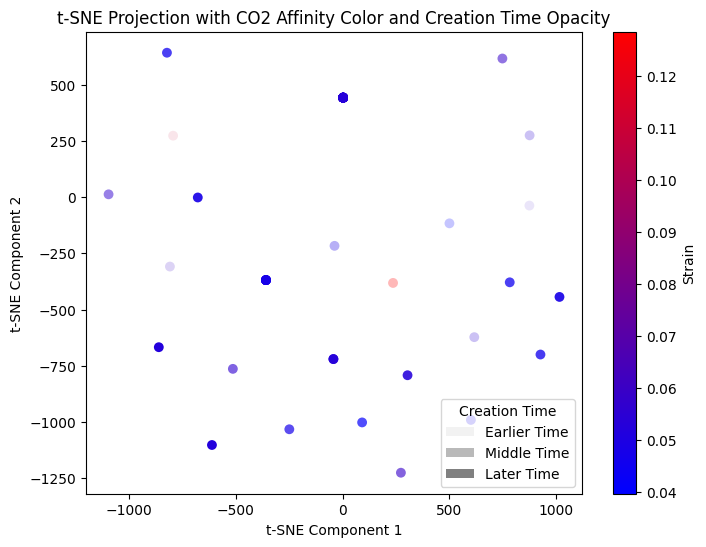

In [51]:
plot_tsne_with_strain_and_time(projected_features, clean_df)

In [94]:
records = []
with gzip.open(file_path, 'rt') as fp:
    for line in tqdm(fp):
        record = json.loads(line)

        # Remove structure data, label linkers by anchor
        for k in ['md_trajectory', 'nodes', 'structure', '_id']:
            del record[k]
        for ligand in record.pop('ligands'):
            record[f'ligand.{ligand["anchor_type"]}'] = ligand
            for k in ['xyz', 'dummy_element', 'anchor_type']:
                del ligand[k]
        co2 = record.get('gas_storage').get('CO2')
        if co2:
            record['co2_affin'] = co2[1]
        else:
            record['co2_affin'] = np.nan
        record['time'] = record.pop('times')['created']['$date']
        records.append(pd.json_normalize(record))
records = pd.concat(records, ignore_index=True)

0it [00:00, ?it/s]

In [96]:
records[~records['gas_storage.CO2'].isna()].shape

(37, 15)

In [97]:
records[~records['co2_affin'].isna()].shape

(37, 15)

In [98]:
records['model_version'] = records[['ligand.cyano.metadata.model_version', 'ligand.COO.metadata.model_version']].max(axis=1)
records['time'] = records['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
records['walltime'] = (records['time'] - records['time'].min()).apply(lambda x: x.total_seconds())
records.sort_values('walltime', inplace=True)

In [102]:
def plot_violin_by_time(data, time_col, y_col, y_name, model_version_col, bin_width, figsize=(3.5, 2), dpi=320, save_path='figures/stability-over-time-violin.png'):
    df = data.copy()
    df['Time Bin'] = np.floor(df[time_col] / 60 / bin_width) * bin_width
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(x='Time Bin', y=y_col, data=df, ax=ax, density_norm='width', palette="muted")

    ax.set_xlabel('Time (min)')
    ax.set_ylabel(f'{y_name}')
    ax.set_title(f'{y_name} by Time Interval')

    fig.tight_layout()
    fig.savefig(save_path, dpi=dpi)
    plt.show()

/var/folders/pb/vktf3d2x011442j3m334qsn80000gn/T/ipykernel_95857/2153838072.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Time Bin', y=y_col, data=df, ax=ax, density_norm='width', palette="muted")


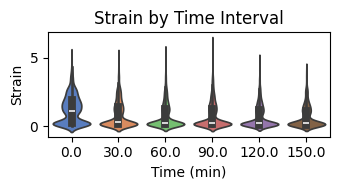

In [105]:
plot_violin_by_time(
    data=records,
    time_col='walltime',
    #gas_storage.CO2
    #structure_stability.uff
    y_col='structure_stability.uff',
    y_name="Strain",
    model_version_col='ligand.cyano.metadata.model_version',
    bin_width=30  # Bin width of minutes
)

/var/folders/pb/vktf3d2x011442j3m334qsn80000gn/T/ipykernel_95857/2153838072.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Time Bin', y=y_col, data=df, ax=ax, density_norm='width', palette="muted")


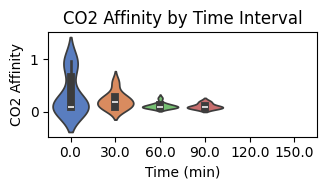

In [103]:
plot_violin_by_time(
    data=records,
    time_col='walltime',
    #gas_storage.CO2
    #structure_stability.uff
    y_col='co2_affin',
    y_name="CO2 Affinity",
    model_version_col='ligand.cyano.metadata.model_version',
    bin_width=30  # Bin width of minutes
)

In [ ]:
#plot_tsne_projection(features[essential_plot_cols])

In [ ]:
#plot_tsne_projection_time_and_strain(features)